In [ ]:
#|hide
#| eval: false
! pip install -Uqq wandb  # install wandb

In [ ]:
#|default_exp performance

# Model performance

> This notebook will compare performance of FFF with FeedForward models

In [ ]:
#|hide
import nbdev
import math
import torch
import FastFF.fff as fff
from FastFF.activations import *
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch import tensor
from torchvision.datasets import MNIST

In [ ]:
#|export
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *

In [ ]:
#|hide
set_seed(0)
n_cores = num_cpus()
device = default_device()

In [ ]:
#|hide
mean, std = 0.130652368068695068, 0.307504087686538696
bs = 256
tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)),
                 T.Lambda(lambda x: x.view(-1,28*28).squeeze())])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)

## Wandb

In [ ]:
#|hide
#|eval: false
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: slakter. Use `wandb login --relogin` to force relogin


True

Initialize sweep parameters

In [ ]:
#|export
def run_sweep(train_ds, test_ds, prm_model,sweep_cfg,
              metrics = accuracy,
              loss = F.cross_entropy,
              opt = Adam,
              cfg = None,
              before_learn_cb=None, project=None, count=5, seed=0):
    def _f(cfg=cfg):
        with wandb.init(config=cfg):
            if seed is not None: set_seed(seed)
            cfg = wandb.config
            model = prm_model(**cfg.model)
            dls = DataLoaders(TfmdDL(train_ds, cfg.bs, True),TfmdDL(test_ds, cfg.bs, False))
            learn = Learner(dls, model, loss_func=loss, metrics=metrics, opt_func = opt)
            if before_learn_cb: before_learn_cb(learn, model, dls)
            learn.fit_one_cycle(cfg.epochs, **cfg.learn)
    
    sweep_id = wandb.sweep(sweep_cfg, project=project)
    wandb.agent(sweep_id, _f, count=count)

In [ ]:
sweep_cfg = {
    'name': 'activations-sweep',
    'method': 'random',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'values': [128,256,512]},
        'learn':{'parameters':{'lr_max': {'value':1e-2}}},
        'model':{'parameters':{
            'h': {'values': [16,32,64,128,256]},
            'act': {'values': ['relu','selu','gelu','prelu']}
            }},
        'epochs': {'value': 15}
    }
}

Create parametrized feedforward model with 2 parameters from sweep_cfg above: `h` and `act`

In [ ]:
def prm_model_ff(h=32,act='relu'):
    acts = {'relu': nn.GELU, 'gelu': nn.GELU, 'selu': nn.SELU, 'prelu': nn.PReLU}
    return nn.Sequential(
        nn.Linear(28*28, h),
        acts[act](),
        nn.Linear(h, 10))

In [ ]:
#|eval: false
run_sweep(train_dataset, test_dataset, prm_model_ff, sweep_cfg, project="FFF", count=10)

## FFF performance and leaves distribution

In [ ]:
#|export
class FFFLeavesDistCB(Callback):
    '''Gets data from leaves of FFF module and logs to wandb if enabled'''
    def __init__(self, use_wandb=False, module=None, sample_size=30):
        self.sample_size = sample_size
        self.module = module
        self.wandb = use_wandb
 
    def before_fit(self): 
        self.module = ifnone(self.module, self.learn.model)
        self.total_leaves = getattr(self.module, 'total_leaves', None)
        if self.wandb: self._wandb_step = wandb.run.step - 1
        self.data = []

    def before_epoch(self): 
        self.tree_leaves, self.preds = [], []
        self.xs, self.ys = [], []
    
    def after_batch(self): 
        if self.training: 
            if self.wandb:  self._wandb_step += 1
            self.tree_leaves.append(self.module.leaves.argmax(1))
            self.preds.append(self.pred.argmax(1))
            self.xs.append(self.xb[0]), self.ys.append(self.yb[0])
             
    def after_epoch(self):
        leaves, preds = torch.cat(self.tree_leaves),torch.cat(self.preds)
        xs, ys = torch.cat(self.xs), torch.cat(self.ys)
        self.data.append((xs,ys,leaves,preds))
        if self.wandb: 
            fig, axs = subplots()
            self.leaf_hist(-1, ax=axs[0], show=False)
            handles, labels = axs[0].get_legend_handles_labels()
            fig.legend(handles, labels)
            wandb.log({"Leaf distribution": fig}, step = self._wandb_step)
    
    def after_fit(self):
        leaves = torch.cat(self.tree_leaves)
        idx = torch.randperm(leaves.size(0))[:self.sample_size]
        xs, ys, preds = torch.cat(self.xs), torch.cat(self.ys), torch.cat(self.preds)
        xs, ys, preds, leaves = xs[idx], ys[idx], preds[idx], leaves[idx]
        if self.wandb:
            cols = ['leaf','image','pred','target']
            data = [[l,wandb.Image(i.view(28,28)),p,y] for l,i,p,y in zip(leaves,xs,preds,ys)]
            wandb.log({"samples": wandb.Table(data=data, columns=cols)})
    
    def leaf_hist(self, epoch_idx, ax=None, show=True):
        leaves, lbls = self.data[epoch_idx][2], self.data[epoch_idx][1]
        if not self.total_leaves: self.total_leaves = leaves.unique().max()+1
        if not ax: ax = subplots()[1][0]
        bottom, bins = torch.zeros(self.total_leaves), L(range(self.total_leaves)).map(str)
        for d in range(10):
            hist = torch.bincount(leaves[lbls==d], minlength=self.total_leaves)
            ax.bar(bins, hist, label=str(d),bottom=bottom)
            bottom += hist
        if show: 
             ax.legend(); plt.show()


In [ ]:
#|hide
#|eval: false
wandb.init(project='FFF')

In [ ]:
#|hide
#|eval: false
model_fff = nn.Sequential(nn.Linear(28*28,32), nn.ReLU(),  fff.FFF(32, 16, 10, 3))
dls = DataLoaders(TfmdDL(train_dataset, 256, True, num_workers=0),TfmdDL(test_dataset, 256, False, num_workers=0))
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam)

In [ ]:
#|eval: false
cbs = [FFFLeavesDistCB(True, model_fff[-1], 40), WandbCallback(log_preds=False)]
learn.fit_one_cycle(10, lr_max=2e-2, cbs=cbs);

<matplotlib.legend.Legend>

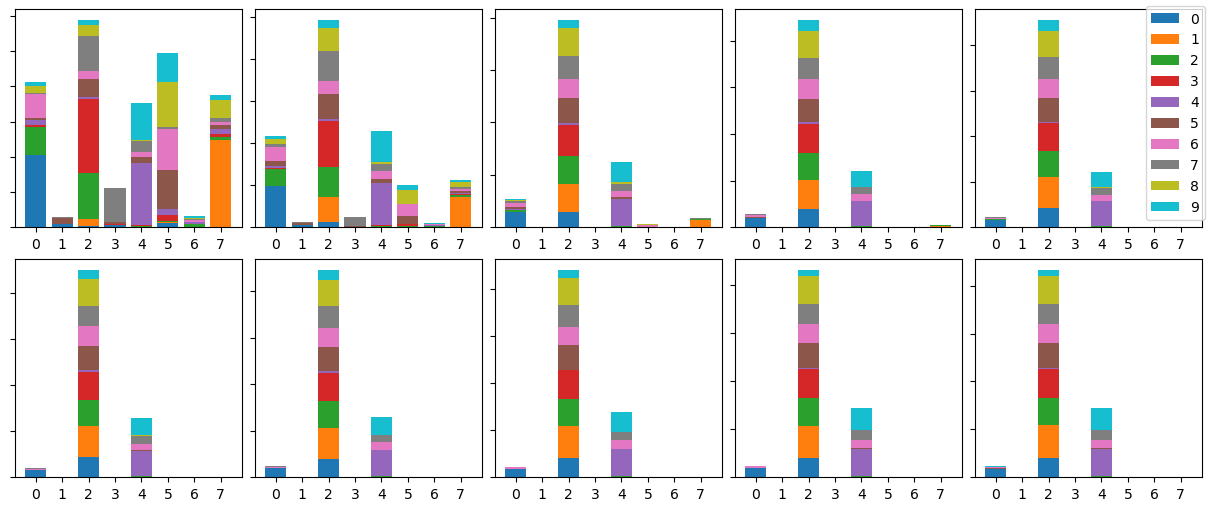

In [ ]:
#|eval: false
n_epoch = 10
ncols = 5
fig, axes = subplots(ncols=ncols, nrows=math.ceil(n_epoch/ncols),
                     figsize=(12,5), layout="constrained")
for i in range(n_epoch):
        ax =  axes[i//ncols][i%ncols] if math.ceil(n_epoch/ncols)>1 else axes[i%ncols]
        ax.set_yticklabels([])
        cbs[0].leaf_hist(i, ax=ax, show=False)

handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels)

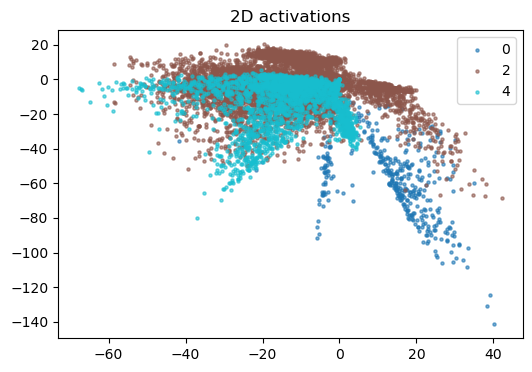

In [ ]:
#|eval: false
cbs = LeavesColors(model_fff, model_fff)
learn.get_preds(dl=dls.valid, cbs = cbs)
cbs.show_acts(figsize = (6,4))

## Sweep for fff

In [ ]:
sweep_cfg = {
    'name': 'narrow-leafs-sweep',
    'method': 'random',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'value': 256},
        'learn':{'parameters':{'lr_max': {'value':2e-2}}},
        'model':{'parameters':{
            'w': {'values': [1,2,4,8]},
            'd': {'values': [1,2,3]},
            'act': {'value': 'relu'},
            'region_leak': {'min':0, 'max':0.5}
            }},
        'epochs': {'value': 15}
    }
}

def prm_model(w=32, d=3, act='relu', dropout=0, region_leak=0):
    acts = {'relu': nn.GELU, 'gelu': nn.GELU, 'selu': nn.SELU, 'prelu': nn.PReLU}
    return fff.FFF(28*28, w, 10, depth = d, region_leak=region_leak, dropout=dropout, activation=acts[act]())

def before_learn_cb(learn, model, *args, **kwargs):
    learn.add_cbs([FFFLeavesDistCB(use_wandb = True, sample_size=100), WandbCallback(log_preds=False)])

In [ ]:
#|eval: false
cbs = [FFFLeavesDistCB(use_wandb = True), WandbCallback(log_preds=False)]
run_sweep(train_dataset, test_dataset, prm_model, sweep_cfg, project="FFF", before_learn_cb=before_learn_cb, count=6,seed=None)